# Introduction:
 

I frequently use a 4D dataset. (3 spatial dimensions + 1 temporal dimension) 
Sometimes, I just like to see a crosssection of the data; however, an arbitrary cross-section is rather hard to get.
x-/y-/z-slices are easy but what would you do if the normal vector of the cross-section is not parallel to one of the directions of the array?

In the past, I used a brute-force algorithm. The basic idea was to make an orthogonal basis with a normal and a point that together define a plane.
Then, check the points spanned by the new basis were inside the cuboid. 
This was inefficient but it worked robustly. 

The time has come to improve this algorithm. Let's get to it.



In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import itertools

In [2]:
## Plotting helpers

def draw_cuboid(ax, xx, yy, zz, color='c', lw=2, **kwargs):
    """Draws a cuboid (projection='3d')"""

    xmin, xmax = np.nanmin(xx), np.nanmax(xx)
    ymin, ymax = np.nanmin(yy), np.nanmax(yy)
    zmin, zmax = np.nanmin(zz), np.nanmax(zz)
    rx = [xmin, xmax]
    ry = [ymin, ymax]
    rz = [zmin, zmax]
    w, h, d = xmax - xmin, ymax - ymin, zmax - zmin
    for s, e in itertools.combinations(np.array(list(itertools.product(rx, ry, rz))), 2):
        dist = np.linalg.norm(s - e)
        if dist in [w, h, d]:
            ax.plot3D(*zip(s, e), color=color, lw=lw, **kwargs)

    ax.set_xlim(rx)
    ax.set_ylim(ry)
    ax.set_zlim(rz)
    set_axes_equal(ax)
    
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

# snippet(s)
def mag(x, axis=-1):
    return np.sum(np.asarray(x) ** 2, axis=axis) ** 0.5



# Find the vertices of the cross-section
A cross-section is defined by an intersecting region of an arbitrary plane with a cuboid.  
Let's find the corresponding vertices.  
The equation of a plane is given by <br>
$ax+by+cz = ax_0 + by_0 + cz_0 \equiv d$.
The point ($x_0, y_0, z_0$) lies on the plane. <br>
The normal vector is ($a, b, c$). (Normalize if you wish.)

There are only 12 possible points on the eight edges of the cuboid. They are hard-coded in get_intersecting_vertices()

In [3]:
def get_intersecting_vertices(xxx, yyy, zzz, a, b, c, x0, y0, z0):
    """
    Returns the vertices of the cross-section
    A plane is defined by ax+by+cz=ax0 + by0 + cz0 := d
    A cuboid is given by by xxx, yyy, zzz
    """
    def insideBox(x, y, z, xmin, xmax, ymin, ymax, zmin, zmax):
        return x >= xmin and x <= xmax and y >= ymin and y <= ymax and z >= zmin and z <= zmax
    
    d = a * x0 + b * y0 + c * z0
    
    
    xmin, xmax, ymin, ymax, zmin, zmax = xxx.min(), xxx.max(), yyy.min(), yyy.max(), zzz.min(), zzz.max()
    

    vert01 = [xmax, (d - a * xmax - c * zmin) / b, zmin]
    vert02 = [xmax, (d - a * xmax - c * zmax) / b, zmax]
    vert03 = [xmax, ymin, (d - a * xmax - b * ymin) / c]
    vert04 = [xmax, ymax, (d - a * xmax - b * ymax) / c]
    
    vert05 = [xmin, (d - a * xmin - c * zmin) / b, zmin]
    vert06 = [xmin, (d - a * xmin - c * zmax) / b, zmax]
    vert07 = [xmin, ymin, (d - a * xmin - b * ymin) / c]
    vert08 = [xmin, ymax, (d - a * xmin - b * ymax) / c]
    
    vert09 = [(d - b * ymax - c * zmin) / a, ymax, zmin]
    vert10 = [(d - b * ymax - c * zmax) / a, ymax, zmax]
    vert11 = [(d - b * ymin - c * zmin) / a, ymin, zmin]
    vert12 = [(d - b * ymin - c * zmax) / a, ymin, zmax]
    

    verts = [vert01, vert02, vert03, vert04,
             vert05, vert06, vert07, vert08,
             vert09, vert10, vert11, vert12]
    verts = set([tuple(item) for item in verts])
    verts = [vert for vert in verts if insideBox(vert[0], vert[1], vert[2], xmin, xmax, ymin, ymax, zmin, zmax)]
    if verts == []:
        raise ValueError('Given plane does not intersect with the cuboid')
    else:
        verts = np.stack(verts)
        return verts


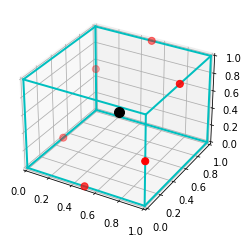

In [4]:
# Define a cuboid
xmin, ymin, zmin = 0, 0, 0 # one vertex of the cuboid
lx, ly, lz = 1, 1, 1 # width, height, depth of the cuboid
xmax, ymax, zmax = xmin + lx, ymin + ly, zmin + lz
x, y, z = np.linspace(xmin, xmax), np.linspace(ymin, ymax), np.linspace(zmin, zmax)
xxx, yyy, zzz = np.meshgrid(x, y, z) # 3d positional grids

## PLANE
# A point that lies on the plane
xo, yo, zo = 0.5, 0.5, 0.5
# A plane: ax + by + cz = a x0 + b y0 + c z0 := d
a, b, c = 0.5, 0.5, -0.5

# GET INTERSECTING VERTICES
verts = get_intersecting_vertices(xxx, yyy, zzz, a, b, c, xo, yo, zo)

# PLOT
fig = plt.figure(1)
ax = plt.subplot(projection='3d')
draw_cuboid(ax, xxx, yyy, zzz)
ax.scatter(verts[:, 0], verts[:, 1], verts[:, 2], color='r', s=50) # Plot the intersecting points
ax.scatter([xo], [yo], [zo], color='k', s=100) # Indicate the point given by the user


/var/folders/fd/rtx3wffn32q9kvg36j597y7c0000gn/T/ipykernel_11172/2011461770.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  vert03 = [xmax, ymin, (d - a * xmax - b * ymin) / c]
/var/folders/fd/rtx3wffn32q9kvg36j597y7c0000gn/T/ipykernel_11172/2011461770.py:19: RuntimeWarning: divide by zero encountered in double_scalars
  vert04 = [xmax, ymax, (d - a * xmax - b * ymax) / c]
/var/folders/fd/rtx3wffn32q9kvg36j597y7c0000gn/T/ipykernel_11172/2011461770.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  vert07 = [xmin, ymin, (d - a * xmin - b * ymin) / c]
/var/folders/fd/rtx3wffn32q9kvg36j597y7c0000gn/T/ipykernel_11172/2011461770.py:24: RuntimeWarning: divide by zero encountered in double_scalars
  vert08 = [xmin, ymax, (d - a * xmin - b * ymax) / c]


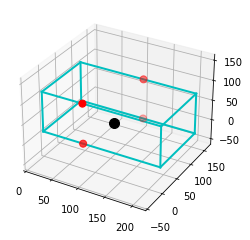

In [5]:
# Define a cuboid
xmin, ymin, zmin = 0, 0, 0 # one vertex of the cuboid
lx, ly, lz = 220, 120, 100 # width, height, depth of the cuboid
xmax, ymax, zmax = xmin + lx, ymin + ly, zmin + lz
x, y, z = np.linspace(xmin, xmax), np.linspace(ymin, ymax), np.linspace(zmin, zmax)
xxx, yyy, zzz = np.meshgrid(x, y, z) # 3d positional grids

## PLANE
# A point that lies on the plane
xo, yo, zo = 100, 60, 20
# A plane: ax + by + cz = a x0 + b y0 + c z0 := d
a, b, c = 0.8, -0.3, 0.0

# GET INTERSECTING VERTICES
verts = get_intersecting_vertices(xxx, yyy, zzz, a, b, c, xo, yo, zo)

# PLOT
fig = plt.figure(1)
ax = plt.subplot(projection='3d')
draw_cuboid(ax, xxx, yyy, zzz)
ax.scatter(verts[:, 0], verts[:, 1], verts[:, 2], color='r', s=50) # Plot the intersecting points
ax.scatter([xo], [yo], [zo], color='k', s=100) # Indicate the point given by the user


In [6]:
# Draw a plane (use plt.scatter for a fake plane)

-0.22460579065115358 1.1575836902790224 -0.5610990015605435 0.785538602184761


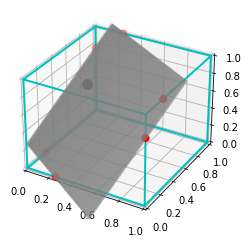

In [7]:
# CUBOID
xmin, ymin, zmin = 0, 0, 0 # one vertex of the cuboid
lx, ly, lz = 1, 1, 1 # width, height, depth of the cuboid
xmax, ymax, zmax = xmin + lx, ymin + ly, zmin + lz
x, y, z = np.linspace(xmin, xmax), np.linspace(ymin, ymax), np.linspace(zmin, zmax)
xxx, yyy, zzz = np.meshgrid(x, y, z) # 3d positional grids
d = min([x[1]-x[0], y[1]-y[0], z[1]-z[0]])

## PLANE
# A point that lies on the plane
xo, yo, zo = 0.1, 0.7, 0.55
ro = np.asarray([xo, yo, zo])
# A plane: ax + by + cz = a x0 + b y0 + c z0 := d
a, b, c = 0.5, 0.5, -0.5
n = np.asarray([a, b, c]) 
n /= mag(n) # Normal vector


verts = get_intersecting_vertices(xxx, yyy, zzz, a, b, c, xo, yo, zo)
roi = verts - np.repeat(ro[np.newaxis, :], verts.shape[0], axis=0)# relative vectors from the reference to the intersecting vertices
dists = mag(roi)

# make an orthonormal basis
e1 = n # normal vector
e2 = verts[np.argmax(dists)] - ro
e2 /= mag(e2)
e3 = np.cross(e1, e2)

# Call the coordinates in the e2-e3 basis as p and q
pmin, pmax = np.min(np.dot(roi, e2)), np.max(np.dot(roi, e2))
qmin, qmax = np.min(np.dot(roi, e3)), np.max(np.dot(roi, e3))
print(pmin, pmax, qmin, qmax)

# now make a grid with the new basis
p = np.linspace(pmin, pmax, int((pmax-pmin)//d))
q = np.linspace(qmin, qmax, int((qmax-qmin)//d))
pp, qq = np.meshgrid(p, q)

xxp = ro[0] + pp * e2[0] + qq * e3[0]
yyp = ro[1] + pp * e2[1] + qq * e3[1]
zzp = ro[2] + pp * e2[2] + qq * e3[2]

# Now make


fig = plt.figure(1)
ax = plt.subplot(projection='3d')
draw_cuboid(ax, xxx, yyy, zzz)

ax.scatter(verts[:, 0], verts[:, 1], verts[:, 2], color='r', s=50)
ax.scatter([xo], [yo], [zo], color='k', s=100)


ax.scatter(xxp.flatten(), yyp.flatten(), zzp.flatten(), color='gray', alpha=0.5, s=5)


# Draw a plane using the PolyCollection
We could use Poly3DCollection to insert a plane in the figure. <br>
To do so, the vertices must be ordered first. Let's update get_intersecting_vertices() with that feature.

-0.28345040051948395 1.1113055385446435 -0.5610862801434217 0.7637007701952129


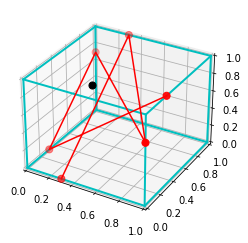

In [8]:
# The intersecting vetices must be sorted.
# CUBOID
xmin, ymin, zmin = 0, 0, 0 # one vertex of the cuboid
lx, ly, lz = 1, 1, 1 # width, height, depth of the cuboid
xmax, ymax, zmax = xmin + lx, ymin + ly, zmin + lz
x, y, z = np.linspace(xmin, xmax), np.linspace(ymin, ymax), np.linspace(zmin, zmax)
xxx, yyy, zzz = np.meshgrid(x, y, z) # 3d positional grids
d = min([x[1]-x[0], y[1]-y[0], z[1]-z[0]])

## PLANE
# A point that lies on the plane
xo, yo, zo = 0.15, 0.7, 0.55
ro = np.asarray([xo, yo, zo])
# A plane: ax + by + cz = a x0 + b y0 + c z0 := d
a, b, c = 0.5, 0.5, -0.5
n = np.asarray([a, b, c]) 
n /= mag(n) # Normal vector


verts = get_intersecting_vertices(xxx, yyy, zzz, a, b, c, xo, yo, zo)
roi = verts - np.repeat(ro[np.newaxis, :], verts.shape[0], axis=0)# relative vectors from the reference to the intersecting vertices
dists = mag(roi)

# make an orthonormal basis
e1 = n # normal vector
e2 = verts[np.argmax(dists)] - ro
e2 /= mag(e2)
e3 = np.cross(e1, e2)

# Call the coordinates in the e2-e3 basis as p and q
pmin, pmax = np.min(np.dot(roi, e2)), np.max(np.dot(roi, e2))
qmin, qmax = np.min(np.dot(roi, e3)), np.max(np.dot(roi, e3))
print(pmin, pmax, qmin, qmax)

# now make a grid with the new basis
p = np.linspace(pmin, pmax, int((pmax-pmin)//d))
q = np.linspace(qmin, qmax, int((qmax-qmin)//d))
pp, qq = np.meshgrid(p, q)

xxp = ro[0] + pp * e2[0] + qq * e3[0]
yyp = ro[1] + pp * e2[1] + qq * e3[1]
zzp = ro[2] + pp * e2[2] + qq * e3[2]

# Now make
fig = plt.figure(1)
ax = plt.subplot(projection='3d')
draw_cuboid(ax, xxx, yyy, zzz)

ax.scatter(verts[:, 0], verts[:, 1], verts[:, 2], color='r', s=50)
ax.scatter([xo], [yo], [zo], color='k', s=50)

ax.plot(verts[:, 0], verts[:, 1], verts[:, 2], color='r')


The sorting can be easily achieved since we already have an orthogonal basis that span tha plane. This means that we can assign an angle for each point, and use them to sort the vertices in order.

In [9]:
def sort_n_arrays_using_order_of_first_array(list_of_arrays, element_dtype=tuple):
    """
    Sort a list of N arrays by the order of the first array in the list
    e.g. a=[2,1,3], b=[1,9,8], c=['a', 'b', 'c']
        [a, b, c] -> [(1, 2, 3), (9, 1, 8), ('b', 'a', 'c')]

    Parameters
    ----------
    list_of_arrays: a list of lists/1D-arrays
    element_dtype: data type, default: tuple
        ... This argument specifies the data type of the elements in the returned list
        ... The default data type of the element is tuple because this functon utilizes sorted(zip(...))
        ... E.g. element_dtype=np.ndarray
                -> [a, b, c] -> [np.array([1, 2, 3]),
                                 np.array([9, 1, 8],
                                 np.array(['b', 'a', 'c'], dtype='<U1']

    Returns
    -------
    list_of_sorted_arrays: list of sorted lists/1D arrays

    """

    list_of_sorted_arrays = list(zip(*sorted(zip(*list_of_arrays))))
    if element_dtype == list:
        list_of_sorted_arrays = [list(a) for a in list_of_sorted_arrays]
    elif element_dtype == np.ndarray:
        list_of_sorted_arrays = [np.asarray(a) for a in list_of_sorted_arrays]
    return list_of_sorted_arrays

def get_intersecting_vertices(xxx, yyy, zzz, a, b, c, x0, y0, z0):
    """
    Returns the vertices of the cross-section
    A plane is defined by ax+by+cz=ax0 + by0 + cz0 := d
    A cuboid is expressed by xxx, yyy, zzz
    """
    def mag(x, axis=-1):
        return np.sum(np.asarray(x) ** 2, axis=axis) ** 0.5

    def insideBox(x, y, z, xmin, xmax, ymin, ymax, zmin, zmax):
        return x >= xmin and x <= xmax and y >= ymin and y <= ymax and z >= zmin and z <= zmax

    d = a * x0 + b * y0 + c * z0

    xmin, xmax, ymin, ymax, zmin, zmax = xxx.min(), xxx.max(), yyy.min(), yyy.max(), zzz.min(), zzz.max()

    vert01 = [xmax, (d - a * xmax - c * zmin) / b, zmin]
    vert02 = [xmax, (d - a * xmax - c * zmax) / b, zmax]
    vert03 = [xmax, ymin, (d - a * xmax - b * ymin) / c]
    vert04 = [xmax, ymax, (d - a * xmax - b * ymax) / c]
    
    vert05 = [xmin, (d - a * xmin - c * zmin) / b, zmin]
    vert06 = [xmin, (d - a * xmin - c * zmax) / b, zmax]
    vert07 = [xmin, ymin, (d - a * xmin - b * ymin) / c]
    vert08 = [xmin, ymax, (d - a * xmin - b * ymax) / c]
    
    vert09 = [(d - b * ymax - c * zmin) / a, ymax, zmin]
    vert10 = [(d - b * ymax - c * zmax) / a, ymax, zmax]
    vert11 = [(d - b * ymin - c * zmin) / a, ymin, zmin]
    vert12 = [(d - b * ymin - c * zmax) / a, ymin, zmax]
    

    verts = [vert01, vert02, vert03, vert04,
             vert05, vert06, vert07, vert08,
             vert09, vert10, vert11, vert12]
    verts = set([tuple(item) for item in verts])
    verts = [vert for vert in verts if insideBox(vert[0], vert[1], vert[2], xmin, xmax, ymin, ymax, zmin, zmax)]
    inds = [i for i, vert in enumerate(verts) if insideBox(vert[0], vert[1], vert[2], xmin, xmax, ymin, ymax, zmin, zmax)]

    if verts == []:
        raise ValueError('Given plane does not intersect with the cuboid')
    else:
        verts = np.stack(verts)
        rg = np.nanmean(verts, axis=0) # centroid will be used to fiugre out the order of the vertices
        # sort vertices
        n = np.asarray([a, b, c])
        e1 = n = n/mag(n)
        e2 = verts[0]-rg # consider a relative vector to a vertex from the centroid as one of the basis vectors
        e2 /= mag(e2)
        e3 = np.cross(e1, e2)
        ps = np.dot(e2, (verts-rg).T)
        qs = np.dot(e3, (verts-rg).T)
        angles = np.arctan2(qs, ps)

        angles, verts = sort_n_arrays_using_order_of_first_array([angles, verts])
        verts = np.asarray(verts)
        return verts

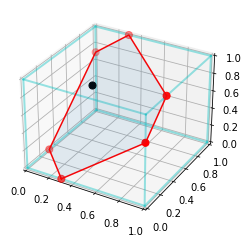

In [10]:
# Draw a plane using the PolyCollection

from mpl_toolkits.mplot3d.art3d import Poly3DCollection

n = np.asarray([a, b, c]) 
n /= mag(n) # Normal vector


fig = plt.figure(1)
ax = plt.subplot(projection='3d')
draw_cuboid(ax, xxx, yyy, zzz, color='c', alpha=0.4) 
verts = get_intersecting_vertices(zzz, xxx, yyy, n[0], n[1], n[2], xo, yo, zo)
verts = np.concatenate([verts, verts[0:1]]) # Include the first point to close the contour properly

ax.scatter(verts[:-1, 0], verts[:-1, 1], verts[:-1, 2], color='r', s=50)
ax.plot(verts[:, 0], verts[:, 1], verts[:, 2], color='r')
plane = Poly3DCollection([verts], alpha=0.1) # intersecting plane
ax.scatter([xo], [yo], [zo], color='k', s=50)

ax.add_collection3d(plane)

Great. All the vertices are sorted in an intuitive manner.

# Application
I needed this feature for my fluid mechanics research but you can of course use it for something else.  
Let's use an MRI data as an example.

In [11]:
## Example: MRI data

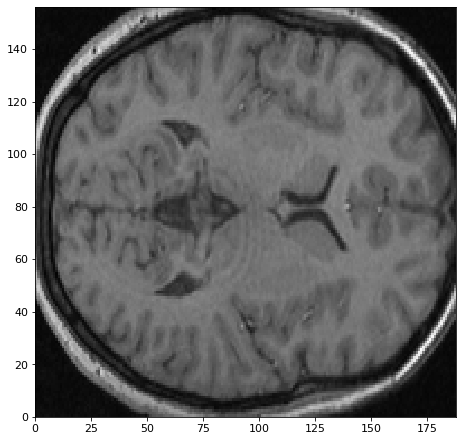

In [44]:
from skimage import io
vol = io.imread("https://s3.amazonaws.com/assets.datacamp.com/blog_assets/attention-mri.tif")
nx, ny, nz = vol.shape
x, y, z = np.arange(nx)*1., np.arange(ny)*1., np.arange(nz)*1.
xx, yy = np.meshgrid(y, x)
xxx, yyy, zzz = np.meshgrid(y, x, z)

plt.pcolormesh(xx, yy, vol[..., 30], cmap='gray')

The downloaded MRI data is a 3D array.

(157, 189, 68)

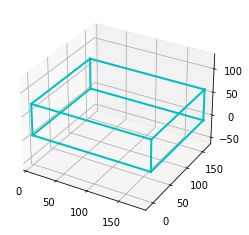

In [13]:
fig = plt.figure(1)
ax = fig.add_subplot(projection='3d')

draw_cuboid(ax, xxx, yyy, zzz)
vol.shape

In [42]:
from scipy.interpolate import RegularGridInterpolator
import tflow.velocity as vel
def interpolate_scalar_field_at_instant_of_time(field, xx, yy, zz=None, t=0, bounds_error=False, **kwargs):
    """
    Returns an interpolating function a scalar field (energy, enstrophy etc.) at instant of time
    using scipy.interpolate.RegularGridInterpolator
    ... field_i( (y, x, z) ): the field at (x, y, z)

    Parameters
    ----------
    field
    xx
    yy
    zz
    t
    bounds_error
    kwargs

    Returns
    -------
    field_i: function
    """
    dim = len(xx.shape)

    try:
        try:
            height, width, depth, duration = field.shape
        except:
            height, width, duration = field.shape
    except:
        field = field.reshape(field.shape + (1,))
        try:
            height, width, depth, duration = field.shape
        except:
            height, width, duration = field.shape

    if zz is not None:
        y, x, z = yy[:, 0, 0], xx[0, :, 0], zz[0, 0, :]
        if np.all(np.diff(z) < 0):
            z = np.flip(z)
            field = np.flip(field, axis=1)
    else:
        y, x = yy[:, 0], xx[0, :]
    if np.all(np.diff(x) < 0):
        x = np.flip(x)
        field = np.flip(field, axis=1)
    if np.all(np.diff(y) < 0):
        y = np.flip(y)
        field = np.flip(field, axis=0)

    if zz is None:
        field_i = RegularGridInterpolator((y, x), field[..., t], bounds_error=bounds_error,
                                          **kwargs)  # interpolating function
    else:
        field_i = RegularGridInterpolator((y, x, z), field[..., t], bounds_error=bounds_error,
                                          **kwargs)
    return field_i

def slicer(xxx, yyy, zzz, n, pt, basis=None, spacing=None, notebook=True, **kwargs):
    def mag(x, axis=-1):
        return np.sum(np.asarray(x) ** 2, axis=axis) ** 0.5

    def get_change_of_basis_matrix(basisA, basisB):
        """
        Returns a change-of-basis matrix from basis A to basis B
        ... each basis must consist of linearly independent vectors

        e.g.
            basis_A = np.asarray([[1, 0, 0],
                                  [0, 1, 0],
                                  [0, 0, 1]])#standard basis
            basis_B = np.asarray([[1,0, 1],
                                  [1,2,4],
                                  [1,-1,-1]])
        """
        a, b = basisA, basisB
        Mae = a  # change of basis from a to a standard basis
        Mbe = b  # change of basis from b to a standard basis
        if np.linalg.det(Mbe) == 0:
            #         print('... change-of-basis matrix is proven to be ALWAYS invertible but the code says it is.')
            print(
                '... You supplied a inappropriate basis for basis B! Probably it is not linearly indepenent. Please check.')
            sys.exit()

        Mab = np.matmul(np.linalg.inv(Mbe),
                        Mae)  # change of basis from a to b, which is equal to the inverse of Mbe since a is a standard basis
        return Mab

    if notebook:
        from tqdm import tqdm_notebook as tqdm
        # print('Using tqdm_notebook. If this is a mistake, set notebook=False')
    else:
        from tqdm import tqdm

    if spacing is None:
        dx, dy, dz = get_grid_spacing(xxx, yyy, zzz)
        spacing = min([dx, dy, dz])
    n = np.asarray(n) / mag(n) # normal vector of the plane
    ro = np.asarray(pt) # a point on the plane
    verts = get_intersecting_vertices(xxx, yyy, zzz, n[0], n[1], n[2], pt[0], pt[1], pt[2])
    roi = verts - np.repeat(ro[np.newaxis, :], verts.shape[0],
                            axis=0)  # relative vectors from the reference to the intersecting vertices
    dists = mag(roi)

    # Basis A (Standard basis)
    basis_std = np.asarray([[1, 0, 0],
                            [0, 1, 0],
                            [0, 0, 1]])  # udata uses a standard basis (y, x, z)

    # Basis B (New orthonormal basis)
    if basis is None:
        e1 = n  # normal vector
        e2 = verts[np.argmax(dists)] - ro
        e2 /= mag(e2)
        e3 = np.cross(e1, e2)
    else:
        e1, e2, e3 = basis[:, 0], basis[:, 1], basis[:, 2]
        e1 /= mag(e1)
        e2 /= mag(e2)
        e3 /= mag(e3)
    basis_npq = np.stack([e1, e2, e3]).T # New coordinates: (n, p, q)

    # Get a change-of_basis matrix
    Mab = get_change_of_basis_matrix(basis_std, basis_npq)
    Mba = np.linalg.inv(Mab)

    # Let the coordinates in the e2-e3 basis be p and q
    pmin, pmax = np.min(np.dot(roi, e2)), np.max(np.dot(roi, e2))
    qmin, qmax = np.min(np.dot(roi, e3)), np.max(np.dot(roi, e3))
    # nmin, nmax = np.min(np.dot(roi, e1)), np.max(np.dot(roi, e1)) # nmin and nmax should be always zero!

    # Now make a grid with the new basis
    p = np.linspace(pmin, pmax, int((pmax - pmin) // spacing))
    q = np.linspace(qmin, qmax, int((qmax - qmin) // spacing))
    pp, qq = np.meshgrid(p, q)

    # Coordinates of points on the plane in the standard basis
    xxp = ro[0] + pp * e2[0] + qq * e3[0]
    yyp = ro[1] + pp * e2[1] + qq * e3[1]
    zzp = ro[2] + pp * e2[2] + qq * e3[2]

    if notebook:
        from tqdm import tqdm as tqdm

    return xxp, yyp, zzp, pp, qq, Mab, Mba, basis_npq

## Get a slice of a 3D scalar field
def slice_3d_scalar_field(field, xx, yy, zz, n, pt, spacing=None,
                          basis=None,
                          showtqdm=True, verbose=False, notebook=True, **kwargs):
    """
    Returns a spatially 2D udata which is on the cross section of a volumetric data
    ... There are two ways to return the velocity field on the cross section.
        1. In the standard basis (xyz, i.e. ux, uy, uz)
        2. In the NEW basis (which I call npq basis, i.e. un, up, uq)
            the basis vector n is identical to the unit area vector of the cross section
    ... By default, this function returns a 2D velocity field in the NEW basis (npq) as well as its coordinates in the same basis.
        ... This is a natural choice since the cross section is spanned by the new basis vectors p and q.
        ... Any postional vector on the cross section is expresed by its linear combinations.
            r = c1 \hat{p} + c2 \hat{q}
            (c1, c2) are the coordinates in the pq basis.
            (Technically, the basis vectors are n, p, q but the coefficient of the n basis vector is always zero on the cross section.)
            By default, this function returns...
            1. velocity field in the NEW basis (npq) on the cross section
            2. Coordinates in the pq basis (technically npq basis, but the coordinate in the basis vector n is always zero so I don't return it)
    ... You CAN retrieve the velocity field in the standard basis (xyz, i.e. ux, uy, uz).
        Just set "u_basis" equal to "xyz"
        If you want both (in npq and xyz basses), set  "u_basis" equal to "both"
    ... If you want a change-of-basis matrix from basis A to basis B, use ilpm.vector.get_change_of_basis_matrix(basisA, basisB)
        e.g.
            Mab = vec.get_change_of_basis_matrix(basis_xyz, basis_npq) # transformation matrix from xyz coords to npq coords
            Mba = np.linalg.inv(Mab) # the change-of-basis matrix is ALWAYS unitary.

    Example:

    Parameters
    ----------
    filed: spatially 3d udata (3D or 4D array) with shape (height, width, depth, duration) or  (dim, height, width, depth)
    xx: 3d array, grid of x-coordinate
    yy: 3d array, grid of y-coordinate
    zz: 3d array, grid of z-coordinate
    n: 1d array-like, area vector (it does not have to be normalized)
    pt: 1d array-like, xyz coordinates of a point on the plane (Note that n and pt uniquely defines a plane)
    spacing: float, must be greater than 0. Sampling spatial resolution on the plane
    show: bool, tflow.graph or takumi.graph is required. If True, it will automatically plot the sampled points on the
        cross section in a 3D view as well as the new basis vectors
    method: str, interpolation method of udata, options: 'nn', 'localmean', 'idw'
        ... volumetric udata may contain lots of np.nan, and cleaning udata often results better results.
        ... 'nn': nearest neighbor filling
        ... 'localmean': filling using a direct covolution (inpainting with a neighbor averaging kernel)
        ... 'idw': filling using a direct covolution (inpainting with a Gaussian kernel)
    max_iter: int, parameter for replacng nans in udata clean_udata()
    tol: float, parameter for replacng nans in udata clean_udata()
    basis: 3x3 matrix, column vectors are the basis vectors.
        ... If given, the basis vectors are used to span the crosss section.
        ... The basis vectors may be rotated or converted to right-handed at the end.
        ...
    apply_convention: bool, If True, it enforces the new basis to follow the convention (right-handed etc.)
    u_basis: str, default: "npq", options: "npq", "xyz" / "standard" "std", "both"
        ... the basis used to represent a velocity field on the plane
        ... "npq": It returns velocity vectors in the npq basis. Returning udata[i, ...] = (un, up, uq)
            (un, up, uq) = (velocity component parallel to the area vector,
                            vel comp parallel to the second basis vector p,
                            vel comp parallel to the second basis vector q)
        ... "xyz". "standard", or "std": It returns velocity vectors in the npq basis. Returning udata[i, ...] = (ux, uy, uz)



    Returns
    -------
    udata_si_npq_basis: udata in the npq basis on the plane spanned by the basis vectors p and q.
        ... its shape is (dim, height, width, duration) = (3, height, width, duration)
        ... udata_si_npq_basis[0, ...] is velocity u \cdot \hat{n}
        ... udata_si_npq_basis[1, ...] is velocity u \cdot \hat{p}
        ... udata_si_npq_basis[2, ...] is velocity u \cdot \hat{q}
    pp: 2d nd array, p-grid
    qq: 2d nd array, q-grid
    """

    if notebook:
        from tqdm import tqdm_notebook as tqdm
        # print('Using tqdm_notebook. If this is a mistake, set notebook=False')
    else:
        from tqdm import tqdm

    if spacing is None:
        dx, dy, dz = get_grid_spacing(xx, yy, zz)
        spacing = min([dx, dy, dz])
#         print('slice_3d_scalar_field:')
#         print('... spacing: ', spacing)

    field = np.asarray(field)
    if len(field.shape) == 3:
        field = field.reshape(field.shape + (1,))
    duration = field.shape[-1]

    # Extract info about the cross section
    xx_plane, yy_plane, zz_plane, pp, qq, Mab, Mba, basis = slicer(xx, yy, zz, n, pt, spacing=spacing, basis=basis, )
    #
    pmin, pmax, qmin, qmax = np.nanmin(pp), np.nanmax(pp), np.nanmin(qq), np.nanmax(qq)
    p = np.linspace(pmin, pmax, int((pmax - pmin) // spacing))
    q = np.linspace(qmin, qmax, int((qmax - qmin) // spacing))
    n = [0]
    pp, qq, nn = np.meshgrid(p, q, n)  # THIS WORKS! DO not touch this
    shape = pp.shape

    for i, t in tqdm(enumerate(range(duration)), disable=not showtqdm):
        fi = interpolate_scalar_field_at_instant_of_time(field, xx, yy, zz, 
                                                         t=t, 
                                                         bounds_error=False) # interpolating function
        field_si = fi((yy_plane, xx_plane, zz_plane))

        if i == 0:
            master_shape = pp.shape[:-1] + (duration,)
            field_si_xyz_basis = np.empty(master_shape)

        field_si_xyz_basis[..., t] = field_si

    field_si_xyz_basis = np.squeeze(field_si_xyz_basis)  # ux, uy, uz

    pp, qq = np.squeeze(pp), np.squeeze(qq)  # 2D grid

    if notebook:
        from tqdm import tqdm as tqdm

    return field_si_xyz_basis, pp, qq

def get_grid_spacing(xx, yy, zz=None):
    dim = len(xx.shape)
    if dim == 2:
        dx = np.abs(xx[0, 1] - xx[0, 0])
        dy = np.abs(yy[1, 0] - yy[0, 0])
        return dx, dy
    elif dim == 3:
        dx = np.abs(xx[0, 1, 0] - xx[0, 0, 0])
        dy = np.abs(yy[1, 0, 0] - yy[0, 0, 0])
        dz = np.abs(zz[0, 0, 1] - zz[0, 0, 0])
        return dx, dy, dz

(156, 154)
(156, 154)


0it [00:00, ?it/s]

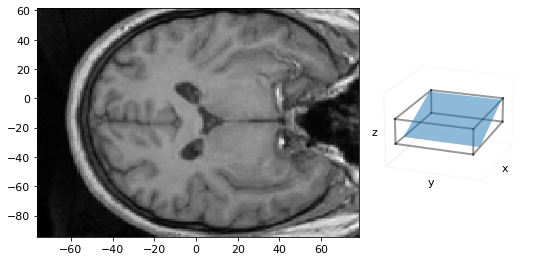

In [45]:
import matplotlib.gridspec as gridspec
def draw_indicator(ax, xx, yy, zz, n, xc=0, yc=0, zc=0, 
                   scale=None, lw=1, alpha=0.5, **kwargs):

    from mpl_toolkits.mplot3d.art3d import Poly3DCollection
    draw_cuboid(ax, xx, yy, zz, color='k', alpha=0.4) 
    verts = get_intersecting_vertices(xx, yy, zz, n[0], n[1], n[2], xc, yc, zc)

    plane = Poly3DCollection([np.concatenate([verts, verts[0:1]])], alpha=alpha, **kwargs) # intersecting plane

    ax.add_collection3d(plane)
    xmin, xmax, ymin, ymax, zmin, zmax = np.nanmin(xx), np.nanmax(xx), np.nanmin(yy), np.nanmax(yy), np.nanmin(zz), np.nanmax(zz)
    w, h, d = xmax - xmin, ymax- ymin, zmax - zmin
#     ax.set_xlim(xmin - 0.2*w, xmin + 1.2*w )
#     ax.set_ylim(ymin - 0.2*h, ymin + 1.2*h )
#     ax.set_zlim(zmin - 0.2*d, zmin + 1.2*d )

    ax.view_init(elev=20., azim=20)


    # Make panes transparent
    ax.xaxis.pane.fill = False # Left pane
    ax.yaxis.pane.fill = False # Right pane
    ax.zaxis.pane.fill = False # Right pane

    # Remove grid lines
    ax.grid(False)

    # Remove tick labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    # Transparent spines
    ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

    # No ticks
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    ax.set_zticks([])

    # no label
    ax.set_xlabel('x', labelpad=-15)
    ax.set_ylabel('y', labelpad=-15)
    ax.set_zlabel('z', labelpad=-15)

theta =  np.pi/7
n = np.asarray([np.sin(theta), 0, np.cos(theta)])

xo, yo, zo = pt =  np.asarray([nx/2., ny/2., nz/2.])

    
fig = plt.figure(figsize=(7.54, 7.54/2), constrained_layout=False)
gs = gridspec.GridSpec(2, 3)
ax = plt.subplot(gs[:, :2])
axInd = plt.subplot(gs[0:, 2:], projection='3d')


cs, pp, qq = slice_3d_scalar_field(vol, xxx, yyy, zzz, n, pt, 
                                   basis=np.asarray([n, [np.cos(theta), 0, -np.sin(theta)], [0, 1, 0]]).T, )
ax.pcolormesh(pp, qq, cs, cmap='gray')

draw_indicator(axInd, xxx, yyy, zzz, n, xc=xo, yc=yo, zc=zo)
fig.tight_layout()


# ipywidgets

In [64]:
from ipywidgets import interact, interactive, fixed, interact_manual, widgets

def slice3DImg(xo=0, yo=0, zo=0, theta=40., phi=0):
    theta =  theta / 180 * np.pi
    phi = phi / 180 * np.pi
#     n = np.asarray([np.cos(phi) * np.sin(theta), np.sin(phi), np.cos(phi) * np.cos(theta)])
    n = np.asarray([np.sin(theta) * np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
    t = np.asarray([np.cos(theta) * np.cos(phi), np.cos(theta)*np.sin(phi), -np.sin(theta)])
    b = np.asarray([-np.sin(phi), np.cos(phi), 0])

#     xo, yo, zo = pt =  np.asarray([nx/2., ny/2., nz/2.])
    pt =  np.asarray([xo, yo, zo])
    
    fig = plt.figure(figsize=(7.54, 7.54/2), constrained_layout=False)
    gs = gridspec.GridSpec(2, 3)
    ax = plt.subplot(gs[:, :2])
    axInd = plt.subplot(gs[0:, 2:], projection='3d')


    cs, pp, qq = slice_3d_scalar_field(vol, xxx, yyy, zzz, n, pt, 
                                       basis=np.asarray([n, t, b]))
    ax.pcolormesh(qq.T, pp.T, cs.T, cmap='gray')
    ax.set_aspect('equal')

    draw_indicator(axInd, xxx, yyy, zzz, n, xc=xo, yc=yo, zc=zo)
    fig.tight_layout()

    
# interactive(slice3DImg, 
#             xo=widgets.FloatSlider(min=np.min(xxx), max=np.max(xxx), step=10., value=(np.max(xxx) - np.min(xxx))/2.), 
#             yo=widgets.FloatSlider(min=np.min(yyy), max=np.max(yyy), step=10., value=(np.max(yyy) - np.min(yyy))/2.), 
#             zo=widgets.FloatSlider(min=np.min(zzz), max=np.max(zzz), step=10., value=(np.max(zzz) - np.min(zzz))/2.), 
#             angle=(0, 180, 10),
#            continuous_update=False)
xo=widgets.FloatSlider(min=np.min(xxx), max=np.max(xxx), step=10., value=(np.max(xxx) - np.min(xxx))/2.)
yo=widgets.FloatSlider(min=np.min(yyy), max=np.max(yyy), step=10., value=(np.max(yyy) - np.min(yyy))/2.) 
zo=widgets.FloatSlider(min=np.min(zzz), max=np.max(zzz), step=10., value=(np.max(zzz) - np.min(zzz))/2.) 
theta=widgets.IntSlider(min=0, max=180, step=10, value=40)
phi=widgets.IntSlider(min=-180, max=180, step=10, value=0)
h1 = widgets.HBox(children=[xo, yo, zo])
h2 = widgets.HBox(children=[theta, phi])
v1 = widgets.VBox(children=[h1,h2])
# plot = interactive(slice3DImg, xo=xo, yo=yo, zo=zo, nx=nx, )

out = widgets.interactive_output(slice3DImg, {'xo': xo, 'yo': yo, 'zo': zo, 'theta': theta, 'phi': phi})

display(v1, out)

# interactive(slice3DImg, v1, continuous_update=False)


Output()

In [47]:
vol.shape

(157, 189, 68)

In [54]:
sl, pp, qq = slice_3d_scalar_field(vol, xxx, yyy, zzz, [0, 1, 0], (94.,  78.,  33.5))

(126, 199)
(126, 199)


0it [00:00, ?it/s]

In [51]:
sl.shape

(119, 199)